In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, UpSampling2D
from tensorflow.keras.models import Model
import os
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path


def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [64, 64])  # Resize images to match HRNet input
    img /= 127.0  # Normalize to [0,1]
    return img

def load_dataset(image_dir):
    image_paths = [str(path) for path in Path(image_dir).glob("*.jpg")]
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(preprocess_image)
    return dataset

# Load your dataset
train_dataset = load_dataset('/content/drive/MyDrive/dacl10k_v2_devphase/dacl10k_v2_devphase/images/train')
train_dataset = train_dataset.batch(32)  # Set the batch size


In [ ]:
import numpy as np
import json
from PIL import Image, ImageDraw
import pandas as pd
import numpy as np
import keras

def create_mask_from_annotation(annot, img_size):
    mask = Image.new('L', img_size, 0)
    for shape in annot['shapes']:
        polygon = [(float(x), float(y)) for x, y in shape['points']]
        ImageDraw.Draw(mask).polygon(polygon, outline=1, fill=1)
    return np.array(mask)

def load_image_and_mask(img_path, annot_path, img_size=(64, 64)):
    img = Image.open(img_path)
    img = img.resize(img_size)
    img = np.array(img, dtype=np.float32) / 255.0  # Normalize and cast to float32

    with open(annot_path, 'r') as file:
        annot = json.load(file)
    mask = create_mask_from_annotation(annot, img_size)
    mask = np.array(mask, dtype=np.uint8)  # Cast mask to uint8
    mask = mask.reshape((*mask.shape, 1))  # Add channel dimension

    return img, mask

def calculate_iou(y_true, y_pred, smooth=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

def calculate_miou(y_true, y_pred, num_classes):
    iou_list = []
    for i in range(num_classes):
        y_true_i = tf.cast(y_true == i, tf.float32)
        y_pred_i = tf.cast(y_pred == i, tf.float32)
        iou_list.append(calculate_iou(y_true_i, y_pred_i))
    miou = tf.reduce_mean(iou_list)
    return miou

def segmentation_accuracy(y_true, y_pred):
    # Convert y_pred to label indices and reshape to match y_true shape
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    y_pred_labels = tf.expand_dims(y_pred_labels, axis=-1)

    # Ensure y_true and y_pred_labels have the same shape
    y_true = tf.cast(y_true, tf.int64)
    y_pred_labels = tf.cast(y_pred_labels, tf.int64)

    # Calculate accuracy
    correct_prediction = tf.equal(y_pred_labels, y_true)
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
def mIoU(y_true, y_pred, num_classes):
    iou_list = IoU_per_class(y_true, y_pred, num_classes)
    m_iou = tf.reduce_mean(iou_list)
    return m_iou

# Named metric functions for use in model.compile
def compute_mIoU(y_true, y_pred):
    return mIoU(y_true, y_pred, num_classes)

def compute_IoU_per_class(y_true, y_pred):
    return IoU_per_class(y_true, y_pred, num_classes)

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.metrics import MeanIoU
from pathlib import Path
import tensorflow as tf
def load_image_only(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Assuming JPEG images
    image = tf.image.resize(image, [64, 64])  # Resize if necessary
    image = image / 255.0  # Normalize pixel values
    return image
def load_dataset(image_dir, annotation_dir=None, batch_size=16, labeled=True):
    image_paths = sorted([str(path) for path in Path(image_dir).glob("*.jpg")])
    if labeled:
        annotation_paths = sorted([str(path) for path in Path(annotation_dir).glob("*.json")])
        paths = (image_paths, annotation_paths)
    else:
        paths = image_paths

    dataset = tf.data.Dataset.from_tensor_slices(paths)
    if labeled:
        dataset = dataset.map(lambda x, y: tf.numpy_function(
                                load_image_and_mask,
                                [x, y],
                                [tf.float32, tf.uint8]),  # Specify output types here
                              num_parallel_calls=tf.data.AUTOTUNE)
    else:
        dataset = dataset.map(lambda x: tf.numpy_function(
                                load_image_only,
                                [x],
                                [tf.float32]),  # Specify output types here
                              num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(lambda x, y: (tf.reshape(x, [64, 64, 3]), tf.reshape(y, [64, 64, 1]))) if labeled else dataset.map(lambda x: tf.reshape(x, [64, 64, 3]))
    dataset = dataset.batch(batch_size)
    return dataset

# Assuming load_image_and_mask and load_image_only functions are defined

# Load datasets
train_dataset = load_dataset('/content/drive/MyDrive/dacl10k_v2_devphase/dacl10k_v2_devphase/images/train', '/content/drive/MyDrive/dacl10k_v2_devphase/dacl10k_v2_devphase/annotations/train')
val_dataset = load_dataset('/content/drive/MyDrive/dacl10k_v2_devphase/dacl10k_v2_devphase/images/validation/', '/content/drive/MyDrive/dacl10k_v2_devphase/dacl10k_v2_devphase/annotations/validation/')
test_dataset = load_dataset('/content/drive/MyDrive/dacl10k_v2_devphase/dacl10k_v2_devphase/images/testdev', labeled=False)

In [ ]:
from tensorflow import keras

def get_optimized_alexnet_segmentation_model(input_shape=(64, 64, 3), num_classes=19):
    model = keras.models.Sequential([
        keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        # Optional: MaxPooling layer can be adjusted or removed depending on the desired level of downsampling

        keras.layers.SeparableConv2D(64, (3, 3), activation='relu', padding='same'),
        # Optional: MaxPooling layer can be adjusted or removed

        keras.layers.SeparableConv2D(128, (3, 3), activation='relu', padding='same'),
        # Optional: MaxPooling layer can be adjusted or removed

        # Upsampling to 64x64
        keras.layers.UpSampling2D((1, 1)),  # This layer will upscale the feature map to 64x64
        keras.layers.Conv2D(128, (2, 2), activation='relu', padding='same'),

        # Final Convolutional Layer for Segmentation Mask
        keras.layers.Conv2D(num_classes, (2, 2), activation='softmax', padding='same')
    ])

    return model

# Instantiate the model
model = get_optimized_alexnet_segmentation_model()

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 separable_conv2d_2 (Separa  (None, 64, 64, 64)        4736      
 bleConv2D)                                                      
                                                                 
 separable_conv2d_3 (Separa  (None, 64, 64, 128)       8896      
 bleConv2D)                                                      
                                                                 
 up_sampling2d_1 (UpSamplin  (None, 64, 64, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 128)       65664     
                                                      

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.metrics import MeanIoU

def compute_mIoU(y_true, y_pred, num_classes):
    # Convert predictions to one-hot encoded format
    y_pred = np.argmax(y_pred, axis=-1)

    # Initialize the MeanIoU object
    miou_calculator = MeanIoU(num_classes=num_classes)

    # Update state with the ground truth and predictions
    miou_calculator.update_state(y_true, y_pred)

    # Return the result
    return miou_calculator.result().numpy()

def evaluate_dataset(dataset, model, num_classes):
    miou_list = []
    for x_batch, y_batch in dataset:
        y_pred = model.predict(x_batch)
        miou = compute_mIoU(y_batch, y_pred, num_classes)
        miou_list.append(miou)

    average_miou = np.mean(miou_list)
    return average_miou

# Define your AlexNet-like model here
def get_optimized_alexnet_segmentation_model(input_shape=(64, 64, 3), num_classes=19):
    model = keras.models.Sequential([
        # Your model layers
    ])
    return model

# Instantiate and compile the model
model = get_optimized_alexnet_segmentation_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Assuming train_dataset, val_dataset, and test_dataset are already defined
epochs = 30
num_classes = 19  # Update this based on your dataset
val_miou_history = []
test_miou_history = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Training phase
    model.fit(train_dataset, epochs=1, validation_data=val_dataset)

    # Evaluation phase
    val_miou = evaluate_dataset(val_dataset, model, num_classes)
    test_miou = evaluate_dataset(test_dataset, model, num_classes)

    # Record the mIoU history
    val_miou_history.append(val_miou)
    test_miou_history.append(test_miou)

    print(f"Validation - Epoch {epoch+1}: mIoU = {val_miou}")
    print(f"Test - Epoch {epoch+1}: mIoU = {test_miou}")

# Plot the mIoU history
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), val_miou_history, label='Validation mIoU')
plt.plot(range(1, epochs+1), test_miou_history, label='Test mIoU')
plt.title("mIoU over Epochs")
plt.xlabel("Epoch")
plt.ylabel("mIoU")
plt.legend()
plt.show()


Epoch 1/30
1/1 [==============================] - 0s 19ms/step


ValueError: ignored

In [ ]:
def evaluate_dataset(dataset, model, num_classes, has_annotations=True):
    miou_list = []
    for batch in dataset:
        if has_annotations:
            x_batch, y_batch = batch
            y_pred = model.predict(x_batch)
            miou = compute_mIoU(y_batch, y_pred, num_classes)
            miou_list.append(miou)
        else:
            # Handle datasets without annotations here
            # For example, just run predictions
            x_batch = batch
            y_pred = model.predict(x_batch)
            # Since we don't have ground truth, we can't compute mIoU
            # You might want to perform some other analysis here

    if has_annotations:
        average_miou = np.mean(miou_list)
        return average_miou
    else:
        # Return some placeholder or different metric for datasets without annotations
        return None


In [ ]:
for epoch in range(epochs):
    # Training phase
    model.fit(train_dataset, epochs=1, validation_data=val_dataset)

    # Evaluation phase
    val_miou = evaluate_dataset(val_dataset, model, num_classes, has_annotations=True)
    test_result = evaluate_dataset(test_dataset, model, num_classes, has_annotations=False)

    # Record the mIoU history for validation
    val_miou_history.append(val_miou)

    print(f"Validation - Epoch {epoch+1}: mIoU = {val_miou}")
    print(f"Test - Epoch {epoch+1}: Result = {test_result}")


1/1 [==============================] - 0s 19ms/step
Validation - Epoch 1: mIoU = 0.204500213265419
Test - Epoch 1: Result = None
1/1 [==============================] - 0s 17ms/step
Validation - Epoch 2: mIoU = 0.204500213265419
Test - Epoch 2: Result = None
1/1 [==============================] - 0s 18ms/step
Validation - Epoch 3: mIoU = 0.204500213265419
Test - Epoch 3: Result = None
1/1 [==============================] - 0s 19ms/step
Validation - Epoch 4: mIoU = 0.204500213265419
Test - Epoch 4: Result = None
1/1 [==============================] - 0s 19ms/step
Validation - Epoch 5: mIoU = 0.204500213265419
Test - Epoch 5: Result = None
1/1 [==============================] - 0s 19ms/step
Validation - Epoch 6: mIoU = 0.204500213265419
Test - Epoch 6: Result = None
1/1 [==============================] - 0s 19ms/step
Validation - Epoch 7: mIoU = 0.204500213265419
Test - Epoch 7: Result = None
1/1 [==============================] - 0s 18ms/step
Validation - Epoch 8: mIoU = 0.20450021326541

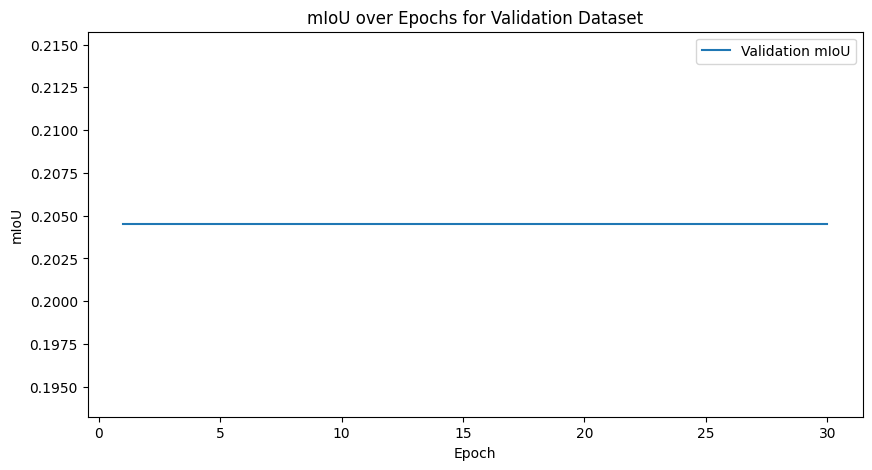

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), val_miou_history, label='Validation mIoU')
plt.title("mIoU over Epochs for Validation Dataset")
plt.xlabel("Epoch")
plt.ylabel("mIoU")
plt.legend()
plt.show()
